# Синтез QPSK с RRC

Параметры:
- Модуляция: QPSK (Gray)
- Отсчётов на символ (sps): 5
- Формирующий фильтр: RRC, alpha = 0.3, span = 10 символов
- Нормированная частотная отстройка: 0.007 циклов/отсчёт
- Начальная фаза: 35°

Результат сохраняется в `qpsk_signal.pcm` как float32 I/Q (I0, Q0, I1, Q1, ...).


In [49]:
import numpy as np
from scipy import signal
from typing import Optional


def rrc_filter(alpha: float, sps: int, span_symbols: int) -> np.ndarray:
    """Импульсная характеристика RRC длиной span_symbols*sps+1."""
    t = np.arange(-span_symbols/2, span_symbols/2 + 1/sps, 1/sps)
    h = np.zeros_like(t)
    eps = 1e-12

    zero_idx = np.abs(t) < eps
    h[zero_idx] = 1 - alpha + 4*alpha/np.pi

    special_idx = np.zeros_like(t, dtype=bool)
    if alpha > 0:
        special_idx = np.isclose(np.abs(t), 1/(4*alpha), atol=1e-12)
        if np.any(special_idx):
            h[special_idx] = (alpha/np.sqrt(2)) * (
                (1 + 2/np.pi) * np.sin(np.pi/(4*alpha)) +
                (1 - 2/np.pi) * np.cos(np.pi/(4*alpha))
            )

    normal_idx = ~(zero_idx | special_idx)
    if np.any(normal_idx):
        tn = t[normal_idx]
        h[normal_idx] = (
            np.sin(np.pi*tn*(1-alpha)) + 4*alpha*tn*np.cos(np.pi*tn*(1+alpha))
        ) / (
            np.pi*tn*(1 - (4*alpha*tn)**2)
        )

    h = h / np.sqrt(np.sum(h**2))
    return h


def qpsk_modulate(
    num_symbols: int,
    sps: int = 5,
    alpha: float = 0.3,
    freq_offset: float = 0.007,
    phase_deg: float = 35.0,
    random_seed: Optional[int] = None,
) -> np.ndarray:
    rng = np.random.default_rng(random_seed)

    constellation = np.array([1+1j, -1+1j, -1-1j, 1-1j], dtype=np.complex64) / np.sqrt(2)
    sym_idx = rng.integers(0, 4, size=num_symbols)
    symbols = constellation[sym_idx]

    h_rrc = rrc_filter(alpha, sps, span_symbols=10)

    shaped = signal.upfirdn(h_rrc, symbols, up=sps)
    gd = (len(h_rrc) - 1) // 2
    shaped = shaped[gd:gd + num_symbols * sps]

    n = np.arange(len(shaped), dtype=np.float64)
    carrier = np.exp(1j * (2*np.pi*freq_offset*n + np.deg2rad(phase_deg)))
    y = shaped * carrier
    return y.astype(np.complex64)


def save_iq_pcm(x: np.ndarray, filename: str) -> None:
    iq = np.empty(2 * len(x), dtype=np.float32)
    iq[0::2] = x.real.astype(np.float32, copy=False)
    iq[1::2] = x.imag.astype(np.float32, copy=False)
    with open(filename, "wb") as f:
        iq.tofile(f)


In [50]:
# Параметры
num_symbols = 1000
sps = 5
alpha = 0.3
freq_offset = 0.007
phase_deg = 35.0
seed = 42

# Генерация
sig = qpsk_modulate(num_symbols, sps, alpha, freq_offset, phase_deg, seed)

# Проверки
assert len(sig) == num_symbols * sps
pavg = float(np.mean(np.abs(sig)**2))
print(f"L={len(sig)}, Pavg={pavg:.4f}")

# Сохранение
save_iq_pcm(sig, "qpsk_signal.pcm")
print("Saved qpsk_signal.pcm")


L=5000, Pavg=0.2000
Saved qpsk_signal.pcm


In [51]:
import numpy.fft as fft


def compute_spectrum(x: np.ndarray, window: str = "hann", fs_hz: float | None = None):
    """
    Возвращает (f_axis, Sdb), где f_axis — нормированная частота (cycles/sample)
    или частота в Гц (если задан fs_hz).
    """
    if window == "hann":
        w = np.hanning(len(x))
    elif window == "hamming":
        w = np.hamming(len(x))
    else:
        w = np.ones(len(x))

    X = fft.fftshift(fft.fft(x * w))
    Sdb = 20 * np.log10(np.maximum(np.abs(X), 1e-12))
    f_norm = np.linspace(-0.5, 0.5, len(X), endpoint=False)
    if fs_hz is None:
        return f_norm, Sdb
    return f_norm * fs_hz, Sdb


def plot_spectrum(f_axis, Sdb, title: str = "Амплитудно-частотный спектр", x_label: str = "Норм. частота (cycles/sample)"):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(7, 3))
    plt.plot(f_axis, Sdb)
    plt.grid(True)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel("Амплитуда, dB")
    plt.tight_layout()
    plt.show()


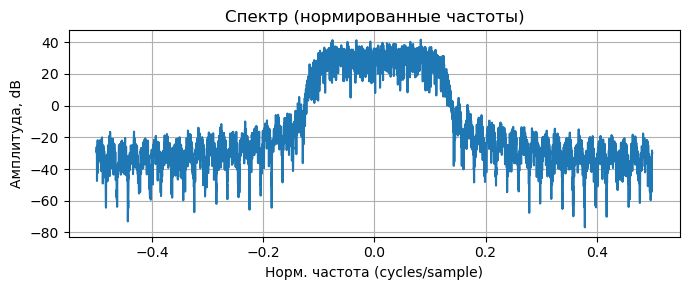

In [52]:
# Спектр в нормированных единицах
f_norm, Sdb = compute_spectrum(sig, window="hann", fs_hz=None)
plot_spectrum(f_norm, Sdb, title="Спектр (нормированные частоты)")


Прочитано: 1573113 отсчётов (complex64), формат int16 I/Q interleaved
Сравнение методов оценки полосы:
     moment: f_center = +0.156191, BW = 1.007547
     energy: f_center = +0.173551, BW = 0.790472
  threshold: f_center = +0.299544, BW = 0.161795

Используем метод 'moment': f_center = +0.156191, BW = 1.007547
Оценённые параметры (норм. частоты, cycles/sample):
  f_center ≈ +0.156191
  f_low    ≈ -0.347583
  f_high   ≈ +0.659964
  BW       ≈ 1.007547
  Rs_norm  ≈ 0.775036  (при alpha≈0.3)


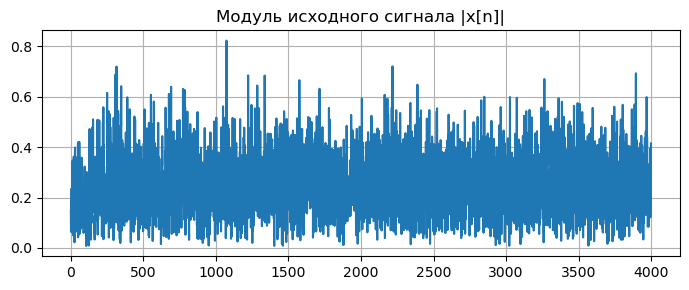

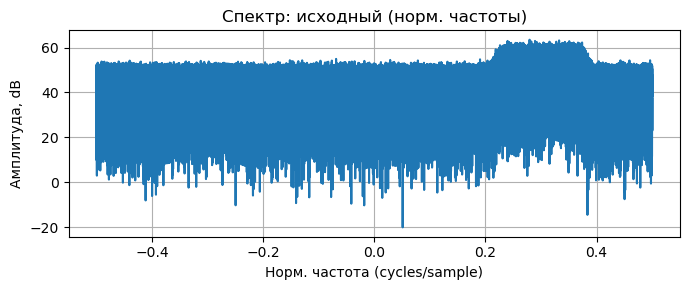

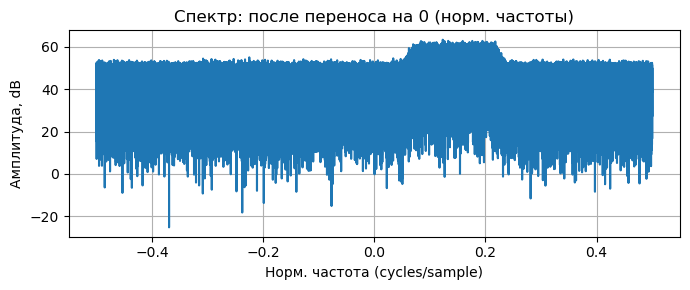

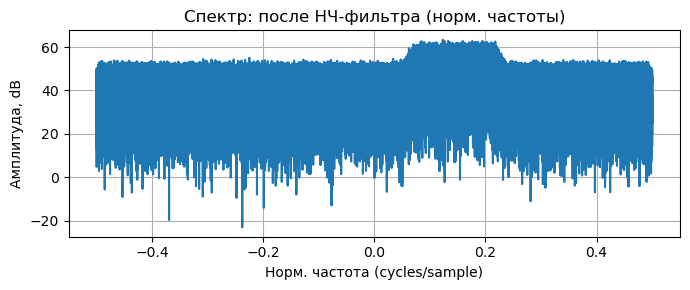

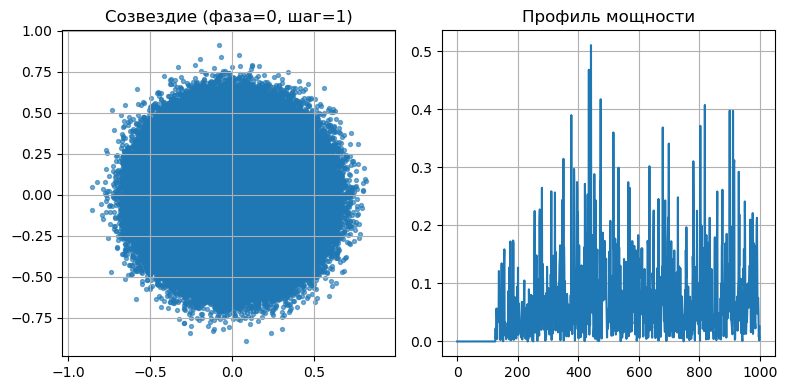

Статистика созвездия: |z|_mean=0.2535, |z|_std=0.1215


In [ ]:
# Пункт 4: анализ файла samples.pcm (I,Q int16 interleaved)
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt


def read_iq_int16(path: str) -> np.ndarray:
    raw = np.fromfile(path, dtype=np.int16)
    if raw.size % 2 != 0:
        raw = raw[:-1]
    iq = raw.reshape(-1, 2).astype(np.float32)
    x = iq[:, 0] + 1j * iq[:, 1]
    # Нормируем к [-1,1)
    x /= 32768.0
    return x.astype(np.complex64)


def estimate_band_edges_advanced(x: np.ndarray, method: str = "moment", 
                                threshold_db: float = -6.0, min_bw_ratio: float = 0.01) -> dict:
    """Улучшенная оценка границ полосы и центральной частоты сигнала"""
    f, Sdb = compute_spectrum(x, window="hann", fs_hz=None)
    
    # Преобразуем в линейную шкалу для расчетов
    S_linear = 10**(Sdb / 10)
    
    if method == "moment":
        # Метод моментов с адаптивным порогом для узкополосных сигналов
        k_peak = np.argmax(Sdb)
        peak_power_db = Sdb[k_peak]
        adaptive_threshold = peak_power_db - 20.0  # 20 dB ниже пика
        valid_mask = Sdb >= adaptive_threshold
        valid_indices = np.where(valid_mask)[0]
        
        if len(valid_indices) > 10:  # Если найдена значимая область
            f_band = f[valid_indices]
            S_band = S_linear[valid_indices]
            total_power = np.sum(S_band)
            f_ctr = np.sum(f_band * S_band) / total_power
            freq_variance = np.sum(((f_band - f_ctr)**2) * S_band) / total_power
            freq_std = np.sqrt(freq_variance)
            f_lo = f_ctr - 3 * freq_std
            f_hi = f_ctr + 3 * freq_std
            bw = 6 * freq_std
        else:
            f_ctr = f[k_peak]
            bw = 0.02  # 2% от Nyquist
            f_lo = f_ctr - bw/2
            f_hi = f_ctr + bw/2
        
    elif method == "energy":
        # Метод по энергии - ищем границы, содержащие 90% энергии
        total_energy = np.sum(S_linear)
        cumulative_energy = np.cumsum(S_linear)
        energy_05 = 0.05 * total_energy
        energy_95 = 0.95 * total_energy
        lo_idx = np.searchsorted(cumulative_energy, energy_05)
        hi_idx = np.searchsorted(cumulative_energy, energy_95)
        f_lo = f[lo_idx]
        f_hi = f[hi_idx] 
        bw = f_hi - f_lo
        band_slice = slice(lo_idx, hi_idx + 1)
        band_power = S_linear[band_slice]
        f_ctr = np.sum(f[band_slice] * band_power) / np.sum(band_power)
        
    else:  # "threshold"
        k_peak = int(np.argmax(Sdb))
        peak_power = Sdb[k_peak]
        threshold = peak_power + threshold_db
        above_thr = Sdb >= threshold
        thr_indices = np.where(above_thr)[0]
        if len(thr_indices) > 0:
            lo_idx, hi_idx = thr_indices[0], thr_indices[-1]
            f_lo, f_hi = f[lo_idx], f[hi_idx]
            bw = f_hi - f_lo
            band_slice = slice(lo_idx, hi_idx + 1)
            band_power = S_linear[band_slice]
            f_ctr = np.sum(f[band_slice] * band_power) / np.sum(band_power)
        else:
            f_ctr = f[k_peak]
            width = len(f) // 20
            lo_idx = max(0, k_peak - width)
            hi_idx = min(len(f) - 1, k_peak + width)
            f_lo, f_hi = f[lo_idx], f[hi_idx]
            bw = f_hi - f_lo
    
    # Проверим минимальную полосу
    min_bw = min_bw_ratio * (f[-1] - f[0])
    if bw < min_bw:
        print(f"Предупреждение: найденная полоса {bw:.6f} слишком узкая, расширяю до {min_bw:.6f}")
        half_min_bw = min_bw / 2
        f_lo = f_ctr - half_min_bw
        f_hi = f_ctr + half_min_bw
        bw = min_bw
    
    return dict(f=f, Sdb=Sdb, f_lo=float(f_lo), f_hi=float(f_hi), 
                f_ctr=float(f_ctr), bw=float(bw), method=method)


def estimate_band_edges(x: np.ndarray, thr_db: float = -10.0) -> dict:
    """Обертка для обратной совместимости"""
    return estimate_band_edges_advanced(x, method="moment", min_bw_ratio=0.01)


def freq_shift(x: np.ndarray, f_norm: float) -> np.ndarray:
    n = np.arange(len(x), dtype=np.float64)
    return x * np.exp(-1j * 2 * np.pi * f_norm * n)


def lowpass_fir(numtaps: int, cutoff_cyc: float, transition: float = 0.1) -> np.ndarray:
    # cutoff_cyc в cycles/sample. firwin использует нормировку к Nyquist => умножаем на 2
    cutoff = min(0.499, cutoff_cyc * (1.0 + transition))
    cutoff_nyq = min(0.999, cutoff / 0.5)
    h = signal.firwin(numtaps=numtaps, cutoff=cutoff_nyq, window="hann", pass_zero="lowpass")
    # Нормировка по энергии, чтобы не занижать мощность
    h /= np.sqrt(np.sum(h**2))
    return h.astype(np.float64)


# Чтение
try:
    x = read_iq_int16("/Users/borispopko/Documents/Dev/stc_test/samples.pcm")
except FileNotFoundError:
    print("samples.pcm не найден — пропускаю пункт 4")
    x = None

if x is not None:
    print(f"Прочитано: {len(x)} отсчётов (complex64), формат int16 I/Q interleaved")

    # Спектр исходного сигнала
    f0, S0 = compute_spectrum(x, window="hann", fs_hz=None)

    # Сравним разные методы оценки границ полосы
    print("Сравнение методов оценки полосы:")
    
    methods = ["moment", "energy", "threshold"]
    estimates = {}
    
    for method in methods:
        est = estimate_band_edges_advanced(x, method=method, min_bw_ratio=0.01)
        estimates[method] = est
        f_ctr, bw = est["f_ctr"], est["bw"]
        print(f"  {method:>9}: f_center = {f_ctr:+.6f}, BW = {bw:.6f}")
    
    # Выберем лучший метод (обычно "moment" для узкополосных сигналов)
    best_method = "moment"
    est = estimates[best_method]
    f_lo, f_hi, f_ctr, bw = est["f_lo"], est["f_hi"], est["f_ctr"], est["bw"]
    
    print(f"\nИспользуем метод '{best_method}': f_center = {f_ctr:+.6f}, BW = {bw:.6f}")

    # Перенос на нулевую частоту
    x_bb = freq_shift(x, f_ctr)

    # Спектр после переноса (для проверки центрирования)
    f1, S1 = compute_spectrum(x_bb, window="hann", fs_hz=None)
    
    # Проверим качество центрирования спектра более тщательно
    center_idx = len(S1) // 2
    peak_idx_after = np.argmax(S1)
    offset_from_center = f1[peak_idx_after]
    
    print(f"После переноса: пик на частоте {offset_from_center:+.6f}")
    
    if abs(offset_from_center) > 0.005:  # Порог 0.005 для точности
        print(f"Коррекция: дополнительный сдвиг на {-offset_from_center:.6f}")
        x_bb = freq_shift(x_bb, offset_from_center)
        f1, S1 = compute_spectrum(x_bb, window="hann", fs_hz=None)
        
        new_peak_idx = np.argmax(S1)
        final_offset = f1[new_peak_idx]
        print(f"После коррекции: пик на частоте {final_offset:+.6f}")
    else:
        print("Центрирование хорошее, коррекция не нужна")

    # Низкочастотная фильтрация с увеличенной полосой пропускания
    # Берем полосу чуть шире оценочной для QPSK
    cutoff_freq = max(bw * 0.6, 0.05)  # минимум 5% от Nyquist
    h_lp = lowpass_fir(numtaps=255, cutoff_cyc=cutoff_freq, transition=0.1)
    x_filt = signal.lfilter(h_lp, [1.0], x_bb).astype(np.complex64)

    # Спектр после фильтра
    f2, S2 = compute_spectrum(x_filt, window="hann", fs_hz=None)

    # Грубая оценка символьной скорости (норм.): Rs ≈ BW / (1 + alpha)
    alpha_guess = 0.3
    rs_norm = bw / (1.0 + alpha_guess)

    # Вывод параметров
    print("Оценённые параметры (норм. частоты, cycles/sample):")
    print(f"  f_center ≈ {f_ctr:+.6f}")
    print(f"  f_low    ≈ {f_lo:+.6f}")
    print(f"  f_high   ≈ {f_hi:+.6f}")
    print(f"  BW       ≈ {bw:.6f}")
    print(f"  Rs_norm  ≈ {rs_norm:.6f}  (при alpha≈{alpha_guess})")

    # Графики
    plt.figure(figsize=(7, 3))
    plt.plot(np.abs(x[:4000]))
    plt.title("Модуль исходного сигнала |x[n]|")
    plt.grid(True); plt.tight_layout(); plt.show()

    plot_spectrum(f0, S0, title="Спектр: исходный (норм. частоты)")
    plot_spectrum(f1, S1, title="Спектр: после переноса на 0 (норм. частоты)")
    plot_spectrum(f2, S2, title="Спектр: после НЧ-фильтра (норм. частоты)")

    # Созвездие на решетке символов
    if rs_norm > 1e-6:
        sps_est = max(1, int(round(1.0 / rs_norm)))
        
        # Попробуем разные фазы отсчета для лучшего созвездия
        best_phase = 0
        best_variance = float('inf')
        
        for phase_offset in range(min(sps_est, 10)):
            samples = x_filt[phase_offset::sps_est]
            if len(samples) > 100:
                # Ищем фазу с минимальной дисперсией (более сфокусированное созвездие)
                variance = np.var(np.abs(samples))
                if variance < best_variance:
                    best_variance = variance
                    best_phase = phase_offset
        
        constellation_samples = x_filt[best_phase::sps_est]
        
        # Показываем созвездие
        plt.figure(figsize=(8, 4))
        
        plt.subplot(1, 2, 1)
        plt.scatter(constellation_samples.real, constellation_samples.imag, s=8, alpha=0.6)
        plt.title(f"Созвездие (фаза={best_phase}, шаг={sps_est})")
        plt.axis('equal'); plt.grid(True)
        
        plt.subplot(1, 2, 2)
        # Также покажем зависимость мощности от времени для проверки
        power_profile = np.abs(x_filt)**2
        plt.plot(power_profile[:min(1000, len(power_profile))])
        plt.title("Профиль мощности")
        plt.grid(True)
        
        plt.tight_layout(); plt.show()
        
        # Дополнительная статистика
        mag_mean = np.mean(np.abs(constellation_samples))
        mag_std = np.std(np.abs(constellation_samples))
        print(f"Статистика созвездия: |z|_mean={mag_mean:.4f}, |z|_std={mag_std:.4f}")
    else:
        print("Не удалось оценить символьную скорость")
